In [1]:
import os

import numpy as np

from Architectures.OptimalCNN import OptimalCNN
from DataObjects import DataLoader
import torch.optim as optim
from Architectures.StochasticDepthCNN import StochasticDepthCNN
from utils import *
import matplotlib.pyplot as plt

from typing import Optional, Tuple

In [2]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                num_epochs: int = 10, lr: float = 0.001,
                device: torch.device = None) -> None:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion: nn.Module = nn.CrossEntropyLoss()
    optimizer: torch.optim.Optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss: float = 0.0
        train_correct: int = 0
        total_train: int = 0

        for batch in train_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        model.eval()
        val_loss: float = 0.0
        val_correct: int = 0
        total_val: int = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.data.to(device)
                labels = batch.labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {avg_val_loss:.4f}, Val acc: {val_acc:.4f}")

def evaluate(model: nn.Module,
             test_loader: Optional[DataLoader] = None,
             device: Optional[torch.device] = None) -> Tuple[float, float]:

    if test_loader is None:
        test_dir = os.path.join("Data", "Data_converted", "test")
        test_loader = DataLoader(test_dir, batch_size=64, shuffle=True)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.eval()

    test_loss = 0.0
    test_correct = 0
    total_test = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels).item()
            total_test += labels.size(0)

    avg_test_loss = test_loss / total_test
    test_acc = test_correct / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return avg_test_loss, test_acc

In [10]:
# Setup directories and DataLoaders
train_dir = os.path.join("Data", "Data_converted", "train")
train_dir_aug_auto = os.path.join("Data", "Data_augmented","autoaugment" ,"train")
train_dir_aug_bright = os.path.join("Data", "Data_augmented","brightness" ,"train")
train_dir_aug_gauss = os.path.join("Data", "Data_augmented","gaussian_noise" ,"train")
train_dir_aug_hor = os.path.join("Data", "Data_augmented","horizontal_flip" ,"train")
train_dir_aug_rot = os.path.join("Data", "Data_augmented","rotation" ,"train")

val_dir = os.path.join("Data", "Data_converted", "valid")
val_dir_aug_auto = os.path.join("Data", "Data_augmented","autoaugment" ,"valid")
val_dir_aug_bright = os.path.join("Data", "Data_augmented","brightness" ,"valid")
val_dir_aug_gauss = os.path.join("Data", "Data_augmented","gaussian_noise" ,"valid")
val_dir_aug_hor = os.path.join("Data", "Data_augmented","horizontal_flip" ,"valid")
val_dir_aug_rot = os.path.join("Data", "Data_augmented","rotation" ,"valid")

test_dir = os.path.join("Data", "Data_converted", "test")
test_dir_aug_auto = os.path.join("Data", "Data_augmented","autoaugment" ,"test")
test_dir_aug_bright = os.path.join("Data", "Data_augmented","brightness" ,"test")
test_dir_aug_gauss = os.path.join("Data", "Data_augmented","gaussian_noise" ,"test")
test_dir_aug_hor = os.path.join("Data", "Data_augmented","horizontal_flip" ,"test")
test_dir_aug_rot = os.path.join("Data", "Data_augmented","rotation" ,"test")

train_loader = DataLoader(train_dir, batch_size=32, shuffle=True, max_per_class = 3000)
train_loader_aug_auto = DataLoader(train_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + train_loader
train_loader_aug_bright = DataLoader(train_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + train_loader
train_loader_aug_gauss = DataLoader(train_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + train_loader
train_loader_aug_hor = DataLoader(train_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + train_loader
train_loader_aug_rot = DataLoader(train_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + train_loader

val_loader = DataLoader(val_dir, batch_size=32, shuffle=True, max_per_class = 3000)
val_loader_aug_auto = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + val_loader
val_loader_aug_bright = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + val_loader
val_loader_aug_gauss = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + val_loader
val_loader_aug_hor = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + val_loader
val_loader_aug_rot = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + val_loader

test_loader = DataLoader(val_dir, batch_size=32, shuffle=True, max_per_class = 3000)
test_loader_aug_auto = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + test_loader
test_loader_aug_bright = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + test_loader
test_loader_aug_gauss = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + test_loader
test_loader_aug_hor = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + test_loader
test_loader_aug_rot = DataLoader(val_dir_aug_auto, batch_size=32, shuffle=True, max_per_class = 3000) + test_loader

In [4]:
# Instantiate the model
model_Optimal_I = OptimalCNN(num_classes=10)
# Train the model
train_model(model_Optimal_I, train_loader, val_loader, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Optimal_I, test_loader)
# Save the model
save_model(model_Optimal_I, "Models_Pytorch_saved/model_Optimal_I_trained_saved.pth")

Epoch 1/10 - Train loss: 1.7321, Train acc: 0.3827 | Val loss: 1.7922, Val acc: 0.3991
Epoch 2/10 - Train loss: 1.2058, Train acc: 0.5741 | Val loss: 1.2208, Val acc: 0.5782
Epoch 3/10 - Train loss: 1.0201, Train acc: 0.6423 | Val loss: 1.0606, Val acc: 0.6387
Epoch 4/10 - Train loss: 0.8874, Train acc: 0.6903 | Val loss: 1.0464, Val acc: 0.6453
Epoch 5/10 - Train loss: 0.7689, Train acc: 0.7312 | Val loss: 0.8708, Val acc: 0.7031
Epoch 6/10 - Train loss: 0.6607, Train acc: 0.7687 | Val loss: 1.0503, Val acc: 0.6608
Epoch 7/10 - Train loss: 0.5477, Train acc: 0.8079 | Val loss: 1.0130, Val acc: 0.6863
Epoch 8/10 - Train loss: 0.4474, Train acc: 0.8425 | Val loss: 1.0261, Val acc: 0.6998
Epoch 9/10 - Train loss: 0.3653, Train acc: 0.8734 | Val loss: 1.0399, Val acc: 0.7109
Epoch 10/10 - Train loss: 0.2930, Train acc: 0.8970 | Val loss: 1.1179, Val acc: 0.7049
Test Loss: 1.1324, Test Accuracy: 0.7027
Model saved successfully at Models_Pytorch_saved/model_Optimal_I_trained_saved.pth


In [5]:
# Instantiate the model
model_Optimal_auto = OptimalCNN(num_classes=10)
# Train the model
train_model(model_Optimal_auto, train_loader_aug_auto, val_loader_aug_auto, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Optimal_auto, test_loader_aug_auto)
# Save the model
save_model(model_Optimal_auto, "Models_Pytorch_saved/model_Optimal_auto_trained_saved.pth")

Epoch 1/10 - Train loss: 1.6342, Train acc: 0.4227 | Val loss: 1.6390, Val acc: 0.4607
Epoch 2/10 - Train loss: 1.1668, Train acc: 0.5900 | Val loss: 1.2593, Val acc: 0.5751
Epoch 3/10 - Train loss: 1.0074, Train acc: 0.6461 | Val loss: 1.0025, Val acc: 0.6480
Epoch 4/10 - Train loss: 0.8812, Train acc: 0.6902 | Val loss: 0.9988, Val acc: 0.6478
Epoch 5/10 - Train loss: 0.7649, Train acc: 0.7327 | Val loss: 0.8989, Val acc: 0.6978
Epoch 6/10 - Train loss: 0.6573, Train acc: 0.7698 | Val loss: 0.9574, Val acc: 0.6820
Epoch 7/10 - Train loss: 0.5475, Train acc: 0.8081 | Val loss: 0.9088, Val acc: 0.7056
Epoch 8/10 - Train loss: 0.4432, Train acc: 0.8447 | Val loss: 1.0015, Val acc: 0.7038
Epoch 9/10 - Train loss: 0.3639, Train acc: 0.8738 | Val loss: 1.0698, Val acc: 0.7128
Epoch 10/10 - Train loss: 0.2940, Train acc: 0.8973 | Val loss: 1.1259, Val acc: 0.7059
Test Loss: 1.1235, Test Accuracy: 0.7067
Model saved successfully at Models_Pytorch_saved/model_Optimal_auto_trained_saved.pth


In [6]:
# Instantiate the model
model_Optimal_bright = OptimalCNN(num_classes=10)
# Train the model
train_model(model_Optimal_bright, train_loader_aug_bright, val_loader_aug_bright, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Optimal_bright, test_loader_aug_bright)
# Save the model
save_model(model_Optimal_bright, "Models_Pytorch_saved/model_Optimal_bright_trained_saved.pth")

Epoch 1/10 - Train loss: 1.5888, Train acc: 0.4366 | Val loss: 1.4469, Val acc: 0.4875
Epoch 2/10 - Train loss: 1.1462, Train acc: 0.5985 | Val loss: 1.3822, Val acc: 0.5346
Epoch 3/10 - Train loss: 0.9910, Train acc: 0.6523 | Val loss: 1.2391, Val acc: 0.5922
Epoch 4/10 - Train loss: 0.8567, Train acc: 0.7037 | Val loss: 1.0078, Val acc: 0.6562
Epoch 5/10 - Train loss: 0.7509, Train acc: 0.7381 | Val loss: 0.9311, Val acc: 0.6799
Epoch 6/10 - Train loss: 0.6446, Train acc: 0.7731 | Val loss: 0.9678, Val acc: 0.6768
Epoch 7/10 - Train loss: 0.5386, Train acc: 0.8097 | Val loss: 0.9236, Val acc: 0.7021
Epoch 8/10 - Train loss: 0.4308, Train acc: 0.8501 | Val loss: 0.9410, Val acc: 0.7090
Epoch 9/10 - Train loss: 0.3472, Train acc: 0.8796 | Val loss: 1.0502, Val acc: 0.7155
Epoch 10/10 - Train loss: 0.2959, Train acc: 0.8955 | Val loss: 1.1383, Val acc: 0.7170
Test Loss: 1.1558, Test Accuracy: 0.7149
Model saved successfully at Models_Pytorch_saved/model_Optimal_bright_trained_saved.pth


In [7]:
# Instantiate the model
model_Optimal_gauss = OptimalCNN(num_classes=10)
# Train the model
train_model(model_Optimal_gauss, train_loader_aug_gauss, val_loader_aug_gauss, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Optimal_gauss, test_loader_aug_gauss)
# Save the model
save_model(model_Optimal_gauss, "Models_Pytorch_saved/model_Optimal_gauss_trained_saved.pth")

Epoch 1/10 - Train loss: 1.6542, Train acc: 0.4132 | Val loss: 1.4863, Val acc: 0.4844
Epoch 2/10 - Train loss: 1.1817, Train acc: 0.5866 | Val loss: 1.2906, Val acc: 0.5711
Epoch 3/10 - Train loss: 0.9974, Train acc: 0.6520 | Val loss: 1.0727, Val acc: 0.6296
Epoch 4/10 - Train loss: 0.8798, Train acc: 0.6946 | Val loss: 1.0590, Val acc: 0.6376
Epoch 5/10 - Train loss: 0.7588, Train acc: 0.7361 | Val loss: 0.8568, Val acc: 0.7085
Epoch 6/10 - Train loss: 0.6453, Train acc: 0.7736 | Val loss: 1.0096, Val acc: 0.6727
Epoch 7/10 - Train loss: 0.5422, Train acc: 0.8089 | Val loss: 1.0124, Val acc: 0.6806
Epoch 8/10 - Train loss: 0.4424, Train acc: 0.8414 | Val loss: 0.9972, Val acc: 0.7024
Epoch 9/10 - Train loss: 0.3604, Train acc: 0.8733 | Val loss: 1.0222, Val acc: 0.7066
Epoch 10/10 - Train loss: 0.2893, Train acc: 0.8984 | Val loss: 1.1517, Val acc: 0.7091
Test Loss: 1.1458, Test Accuracy: 0.7089
Model saved successfully at Models_Pytorch_saved/model_Optimal_gauss_trained_saved.pth


In [8]:
# Instantiate the model
model_Optimal_hor = OptimalCNN(num_classes=10)
# Train the model
train_model(model_Optimal_hor, train_loader_aug_hor, val_loader_aug_hor, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Optimal_hor, test_loader_aug_hor)
# Save the model
save_model(model_Optimal_hor, "Models_Pytorch_saved/model_Optimal_hor_trained_saved.pth")

Epoch 1/10 - Train loss: 1.6620, Train acc: 0.4098 | Val loss: 1.3097, Val acc: 0.5331
Epoch 2/10 - Train loss: 1.1813, Train acc: 0.5852 | Val loss: 1.1142, Val acc: 0.6084
Epoch 3/10 - Train loss: 1.0105, Train acc: 0.6499 | Val loss: 1.0345, Val acc: 0.6405
Epoch 4/10 - Train loss: 0.8830, Train acc: 0.6905 | Val loss: 1.0772, Val acc: 0.6391
Epoch 5/10 - Train loss: 0.7660, Train acc: 0.7309 | Val loss: 0.9315, Val acc: 0.6805
Epoch 6/10 - Train loss: 0.6522, Train acc: 0.7725 | Val loss: 1.0161, Val acc: 0.6771
Epoch 7/10 - Train loss: 0.5419, Train acc: 0.8091 | Val loss: 0.8722, Val acc: 0.7134
Epoch 8/10 - Train loss: 0.4397, Train acc: 0.8449 | Val loss: 1.0431, Val acc: 0.7015
Epoch 9/10 - Train loss: 0.3560, Train acc: 0.8734 | Val loss: 1.0601, Val acc: 0.7016
Epoch 10/10 - Train loss: 0.2868, Train acc: 0.8993 | Val loss: 1.1134, Val acc: 0.7028
Test Loss: 1.1278, Test Accuracy: 0.7018
Model saved successfully at Models_Pytorch_saved/model_Optimal_hor_trained_saved.pth


In [9]:
# Instantiate the model
model_Optimal_rot = OptimalCNN(num_classes=10)
# Train the model
train_model(model_Optimal_rot, train_loader_aug_rot, val_loader_aug_rot, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Optimal_rot, test_loader_aug_rot)
# Save the model
save_model(model_Optimal_rot, "Models_Pytorch_saved/model_Optimal_rot_trained_saved.pth")

Epoch 1/10 - Train loss: 1.6204, Train acc: 0.4223 | Val loss: 1.3035, Val acc: 0.5362
Epoch 2/10 - Train loss: 1.1570, Train acc: 0.5978 | Val loss: 1.1963, Val acc: 0.5831
Epoch 3/10 - Train loss: 0.9842, Train acc: 0.6571 | Val loss: 1.0261, Val acc: 0.6423
Epoch 4/10 - Train loss: 0.8534, Train acc: 0.7023 | Val loss: 1.1136, Val acc: 0.6333
Epoch 5/10 - Train loss: 0.7349, Train acc: 0.7436 | Val loss: 0.9581, Val acc: 0.6719
Epoch 6/10 - Train loss: 0.6303, Train acc: 0.7816 | Val loss: 0.9554, Val acc: 0.6862
Epoch 7/10 - Train loss: 0.5152, Train acc: 0.8190 | Val loss: 0.9199, Val acc: 0.7150
Epoch 8/10 - Train loss: 0.4117, Train acc: 0.8565 | Val loss: 0.9677, Val acc: 0.7104
Epoch 9/10 - Train loss: 0.3347, Train acc: 0.8826 | Val loss: 1.1483, Val acc: 0.6772
Epoch 10/10 - Train loss: 0.2644, Train acc: 0.9075 | Val loss: 1.1804, Val acc: 0.7133
Test Loss: 1.1867, Test Accuracy: 0.7153
Model saved successfully at Models_Pytorch_saved/model_Optimal_rot_trained_saved.pth


# Stochastic Deep

In [18]:
loss_tab = []
acc_tab = []
stoch_tab = []

for i in np.arange(0.1, 0.7, 0.1):
    # Instantiate the model
    model_Stochastic = StochasticDepthCNN(num_classes=10, stoch_prob=i)
    # Train the model
    train_model(model_Stochastic, train_loader, val_loader, num_epochs=10, lr=0.008)
    # Evaluate the model
    [loss, acc] = evaluate(model_Stochastic, test_loader)
    # Save the model
    f = i*10
    save_model(model_Stochastic, "Models_Pytorch_saved/model_stochastic_{f}_trained_saved.pth")

    loss_tab.append(loss)
    acc_tab.append(acc)
    stoch_tab.append(i)

Epoch 1/10 - Train loss: 1.7676, Train acc: 0.3763 | Val loss: 1.4992, Val acc: 0.4488
Epoch 2/10 - Train loss: 1.2942, Train acc: 0.5484 | Val loss: 1.3446, Val acc: 0.5260
Epoch 3/10 - Train loss: 1.1320, Train acc: 0.6060 | Val loss: 1.3111, Val acc: 0.5301
Epoch 4/10 - Train loss: 1.0337, Train acc: 0.6406 | Val loss: 1.0528, Val acc: 0.6456
Epoch 5/10 - Train loss: 0.9458, Train acc: 0.6730 | Val loss: 1.2965, Val acc: 0.5652
Epoch 6/10 - Train loss: 0.8768, Train acc: 0.6983 | Val loss: 1.6521, Val acc: 0.4210
Epoch 7/10 - Train loss: 0.8017, Train acc: 0.7208 | Val loss: 2.1695, Val acc: 0.2516
Epoch 8/10 - Train loss: 0.7306, Train acc: 0.7468 | Val loss: 1.1296, Val acc: 0.6001
Epoch 9/10 - Train loss: 0.6671, Train acc: 0.7677 | Val loss: 3.1892, Val acc: 0.1769
Epoch 10/10 - Train loss: 0.5844, Train acc: 0.7991 | Val loss: 3.0090, Val acc: 0.2970
Test Loss: 3.0154, Test Accuracy: 0.2950
Model saved successfully at Models_Pytorch_saved/model_stochastic_{f}_trained_saved.pth


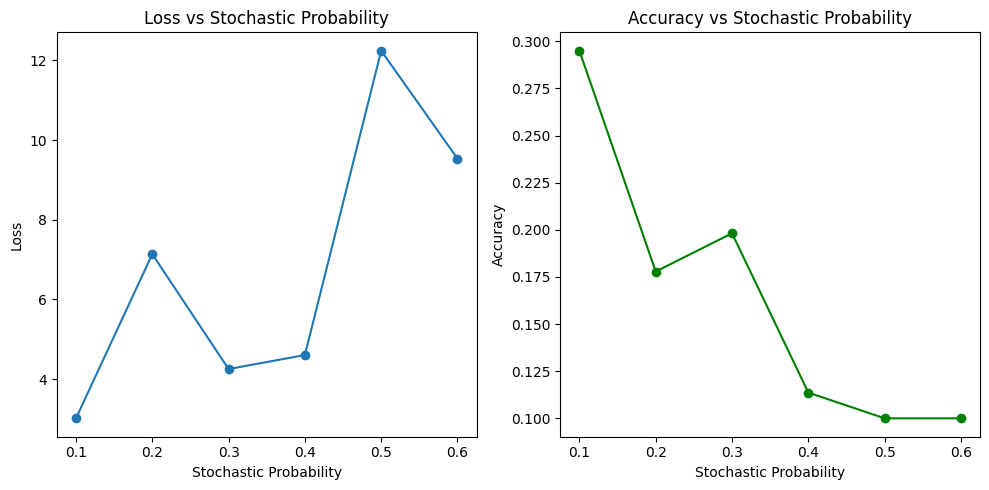

In [11]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(stoch_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Stochastic Probability")
plt.ylabel("Loss")
plt.title("Loss vs Stochastic Probability")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(stoch_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Stochastic Probability")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Stochastic Probability")

plt.tight_layout()
plt.show()

In [12]:
# Instantiate the model
model_Stochastic_auto = StochasticDepthCNN(num_classes=10)
# Train the model
train_model(model_Stochastic_auto, train_loader_aug_auto, val_loader_aug_auto, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Stochastic_auto, test_loader_aug_auto)
# Save the model
save_model(model_Stochastic_auto, "Models_Pytorch_saved/model_Stochastic_auto_trained_saved.pth")

Epoch 1/10 - Train loss: 1.7768, Train acc: 0.3753 | Val loss: 1.6887, Val acc: 0.4032
Epoch 2/10 - Train loss: 1.3306, Train acc: 0.5297 | Val loss: 1.7634, Val acc: 0.3741
Epoch 3/10 - Train loss: 1.1661, Train acc: 0.5906 | Val loss: 1.9568, Val acc: 0.3340
Epoch 4/10 - Train loss: 1.0604, Train acc: 0.6329 | Val loss: 2.6763, Val acc: 0.2461
Epoch 5/10 - Train loss: 0.9787, Train acc: 0.6586 | Val loss: 1.7000, Val acc: 0.4404
Epoch 6/10 - Train loss: 0.9037, Train acc: 0.6852 | Val loss: 4.0613, Val acc: 0.2082
Epoch 7/10 - Train loss: 0.8325, Train acc: 0.7125 | Val loss: 2.4588, Val acc: 0.2161
Epoch 8/10 - Train loss: 0.7594, Train acc: 0.7360 | Val loss: 5.9788, Val acc: 0.1000
Epoch 9/10 - Train loss: 0.6976, Train acc: 0.7555 | Val loss: 6.7478, Val acc: 0.1000
Epoch 10/10 - Train loss: 0.6404, Train acc: 0.7771 | Val loss: 5.8436, Val acc: 0.1000
Test Loss: 5.8380, Test Accuracy: 0.1000
Model saved successfully at Models_Pytorch_saved/model_Stochastic_auto_trained_saved.pth

In [13]:
# Instantiate the model
model_Stochastic_bright = StochasticDepthCNN(num_classes=10)
# Train the model
train_model(model_Stochastic_bright, train_loader_aug_bright, val_loader_aug_bright, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Stochastic_bright, test_loader_aug_bright)
# Save the model
save_model(model_Stochastic_bright, "Models_Pytorch_saved/model_Stochastic_bright_trained_saved.pth")

Epoch 1/10 - Train loss: 1.7917, Train acc: 0.3691 | Val loss: 1.8174, Val acc: 0.3325
Epoch 2/10 - Train loss: 1.3246, Train acc: 0.5333 | Val loss: 1.4756, Val acc: 0.4660
Epoch 3/10 - Train loss: 1.1635, Train acc: 0.5950 | Val loss: 1.4453, Val acc: 0.4794
Epoch 4/10 - Train loss: 1.0646, Train acc: 0.6298 | Val loss: 1.6812, Val acc: 0.3987
Epoch 5/10 - Train loss: 0.9933, Train acc: 0.6592 | Val loss: 1.5539, Val acc: 0.4359
Epoch 6/10 - Train loss: 0.9042, Train acc: 0.6860 | Val loss: 2.5190, Val acc: 0.2531
Epoch 7/10 - Train loss: 0.8412, Train acc: 0.7088 | Val loss: 1.9365, Val acc: 0.3975
Epoch 8/10 - Train loss: 0.7783, Train acc: 0.7306 | Val loss: 2.6689, Val acc: 0.1906
Epoch 9/10 - Train loss: 0.7124, Train acc: 0.7518 | Val loss: 1.9843, Val acc: 0.2855
Epoch 10/10 - Train loss: 0.6450, Train acc: 0.7765 | Val loss: 5.2958, Val acc: 0.1430
Test Loss: 5.2948, Test Accuracy: 0.1417
Model saved successfully at Models_Pytorch_saved/model_Stochastic_bright_trained_saved.p

In [14]:
# Instantiate the model
model_Stochastic_gauss = StochasticDepthCNN(num_classes=10)
# Train the model
train_model(model_Stochastic_gauss, train_loader_aug_gauss, val_loader_aug_gauss, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Stochastic_gauss, test_loader_aug_gauss)
# Save the model
save_model(model_Stochastic_gauss, "Models_Pytorch_saved/model_Stochastic_gauss_trained_saved.pth")

Epoch 1/10 - Train loss: 1.7935, Train acc: 0.3655 | Val loss: 2.0286, Val acc: 0.3284
Epoch 2/10 - Train loss: 1.3299, Train acc: 0.5330 | Val loss: 1.4204, Val acc: 0.4979
Epoch 3/10 - Train loss: 1.1608, Train acc: 0.5940 | Val loss: 1.3141, Val acc: 0.5384
Epoch 4/10 - Train loss: 1.0599, Train acc: 0.6300 | Val loss: 1.6978, Val acc: 0.4031
Epoch 5/10 - Train loss: 0.9842, Train acc: 0.6551 | Val loss: 2.4736, Val acc: 0.2376
Epoch 6/10 - Train loss: 0.8944, Train acc: 0.6890 | Val loss: 2.8385, Val acc: 0.2702
Epoch 7/10 - Train loss: 0.8329, Train acc: 0.7098 | Val loss: 4.5473, Val acc: 0.1626
Epoch 8/10 - Train loss: 0.7475, Train acc: 0.7412 | Val loss: 4.2389, Val acc: 0.1721
Epoch 9/10 - Train loss: 0.6978, Train acc: 0.7564 | Val loss: 4.8568, Val acc: 0.1168
Epoch 10/10 - Train loss: 0.6392, Train acc: 0.7780 | Val loss: 7.6862, Val acc: 0.1035
Test Loss: 7.6874, Test Accuracy: 0.1033
Model saved successfully at Models_Pytorch_saved/model_Stochastic_gauss_trained_saved.pt

In [15]:
# Instantiate the model
model_Stochastic_hor = StochasticDepthCNN(num_classes=10)
# Train the model
train_model(model_Stochastic_hor, train_loader_aug_hor, val_loader_aug_hor, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Stochastic_hor, test_loader_aug_hor)
# Save the model
save_model(model_Stochastic_hor, "Models_Pytorch_saved/model_Stochastic_hor_trained_saved.pth")

Epoch 1/10 - Train loss: 1.7804, Train acc: 0.3701 | Val loss: 1.5941, Val acc: 0.4261
Epoch 2/10 - Train loss: 1.3232, Train acc: 0.5370 | Val loss: 1.4913, Val acc: 0.4818
Epoch 3/10 - Train loss: 1.1640, Train acc: 0.5963 | Val loss: 1.4117, Val acc: 0.5250
Epoch 4/10 - Train loss: 1.0624, Train acc: 0.6288 | Val loss: 1.4892, Val acc: 0.4880
Epoch 5/10 - Train loss: 0.9738, Train acc: 0.6616 | Val loss: 1.4946, Val acc: 0.4749
Epoch 6/10 - Train loss: 0.9004, Train acc: 0.6869 | Val loss: 2.0872, Val acc: 0.3327
Epoch 7/10 - Train loss: 0.8352, Train acc: 0.7117 | Val loss: 3.0878, Val acc: 0.2461
Epoch 8/10 - Train loss: 0.7702, Train acc: 0.7343 | Val loss: 4.2695, Val acc: 0.1304
Epoch 9/10 - Train loss: 0.7045, Train acc: 0.7552 | Val loss: 3.8728, Val acc: 0.1871
Epoch 10/10 - Train loss: 0.6305, Train acc: 0.7820 | Val loss: 5.6850, Val acc: 0.1131
Test Loss: 5.6867, Test Accuracy: 0.1135
Model saved successfully at Models_Pytorch_saved/model_Stochastic_hor_trained_saved.pth


In [16]:
# Instantiate the model
model_Stochastic_rot = StochasticDepthCNN(num_classes=10)
# Train the model
train_model(model_Stochastic_rot, train_loader_aug_rot, val_loader_aug_rot, num_epochs=10, lr=0.008)
# Evaluate the model
evaluate(model_Stochastic_rot, test_loader_aug_rot)
# Save the model
save_model(model_Stochastic_rot, "Models_Pytorch_saved/model_Stochastic_rot_trained_saved.pth")

Epoch 1/10 - Train loss: 1.8224, Train acc: 0.3588 | Val loss: 2.0286, Val acc: 0.2835
Epoch 2/10 - Train loss: 1.3611, Train acc: 0.5172 | Val loss: 2.1819, Val acc: 0.3283
Epoch 3/10 - Train loss: 1.1961, Train acc: 0.5809 | Val loss: 2.4455, Val acc: 0.3419
Epoch 4/10 - Train loss: 1.0808, Train acc: 0.6230 | Val loss: 1.6648, Val acc: 0.4139
Epoch 5/10 - Train loss: 0.9982, Train acc: 0.6544 | Val loss: 1.6354, Val acc: 0.4553
Epoch 6/10 - Train loss: 0.9177, Train acc: 0.6800 | Val loss: 4.2989, Val acc: 0.1496
Epoch 7/10 - Train loss: 0.8409, Train acc: 0.7108 | Val loss: 6.3339, Val acc: 0.1000
Epoch 8/10 - Train loss: 0.7755, Train acc: 0.7296 | Val loss: 5.5547, Val acc: 0.1419
Epoch 9/10 - Train loss: 0.7100, Train acc: 0.7551 | Val loss: 7.4505, Val acc: 0.1000
Epoch 10/10 - Train loss: 0.6512, Train acc: 0.7737 | Val loss: 11.9559, Val acc: 0.1000
Test Loss: 11.9484, Test Accuracy: 0.1000
Model saved successfully at Models_Pytorch_saved/model_Stochastic_rot_trained_saved.pt